<a href="https://colab.research.google.com/github/Emil910/TIU-Emil/blob/main/Fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nbstripout

In [3]:
!nbstripout Fake_news_detector.ipynb

In [ ]:
! pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
from transformers import pipeline
import pandas as pd

# Load the dataset
ds = load_dataset("GonzaloA/fake_news", split="train")
ds2 = load_dataset("GonzaloA/fake_news", split="train")
ds[:5]

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


{'Unnamed: 0': [0, 1, 2, 3, 4],
 'title': [' ‘Maury’ Show Official Facebook Posts F*CKED UP Caption On Guest That Looks Like Ted Cruz (IMAGE)',
  ' Trump’s Favorite News Channel Tries To Soothe His Battered Ego – Gets Taken To The Cleaners',
  'Russia warns Iraq, Kurds not to destabilize Middle East after Kurdish vote',
  'WATCH STEVE SCALISE Throw A Strike At The Nationals Baseball Game [Video]',
  ' Trump Will HATE What Stephen Colbert Just Did To Him – It’s Pure Comedy Genius (VIDEO)'],
 'text': ['Maury is perhaps one of the trashiest shows on television today. It s right in line with the likes of the gutter trash that is Jerry Springer, and the fact that those shows are still on the air with the shit they air really is a sad testament to what Americans find to be entertaining. However, Maury really crossed the line with a Facebook post regarding one of their guest s appearance with a vile, disgusting caption on Tuesday evening.There was a young woman on there doing one of their epi

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("jy46604790/Fake-News-Bert-Detect")
model = AutoModelForSequenceClassification.from_pretrained("jy46604790/Fake-News-Bert-Detect")

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

### **Exploratory Data Analysis**

In [ ]:
df = ds.to_pandas()  # Convert the Hugging Face dataset to a pandas DataFrame for EDA
df.head() # Display the first 5 rows of the DataFrame

,Unnamed: 0,title,text,label
0,0,‘Maury’ Show Official Facebook Posts F*CKED U...,mauri perhap one trashiest show televi today i...,0
1,1,Trump’s Favorite News Channel Tries To Soothe...,yesterday father one ucla player arrest china ...,0
2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",moscow reuter russia wednesday warn iraq kurd ...,1
3,3,WATCH STEVE SCALISE Throw A Strike At The Nati...,hou major whip steve scali r la threw strike c...,0
4,4,Trump Will HATE What Stephen Colbert Just Did...,it said late show host stephen colbert clearli...,0


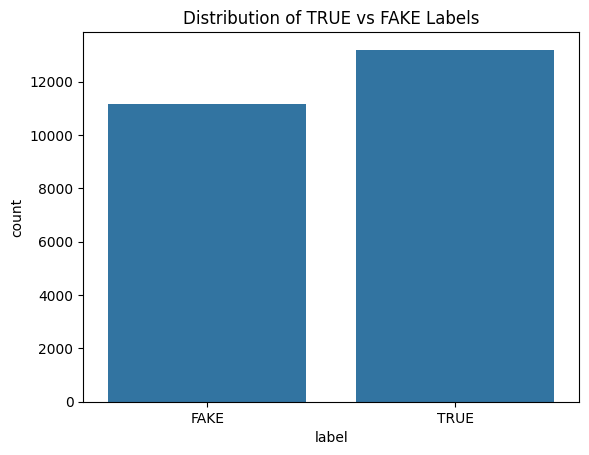

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a countplot using seaborn, showing the distribution of the true and fake news
sns.countplot(x='label', data=df)
plt.xticks([0, 1], ['FAKE', 'TRUE'])
plt.title('Distribution of TRUE vs FAKE Labels')
plt.show()


In [ ]:
# Average lenght of true and fake news in words
avg_length_true = df[df['label'] == 1]['text_length'].mean()
avg_length_fake = df[df['label'] == 0]['text_length'].mean()
print(f'Average Length (TRUE): {avg_length_true}')
print(f'Average Length (FAKE): {avg_length_fake}')


Average Length (TRUE): 239.6714664645699
Average Length (FAKE): 248.1219752643843


In [ ]:
# Print the number of missing values in the 'text' column
print(df['text'].isna().sum())

0


In [ ]:
df.shape # Number of rows and columns of the data

(24353, 5)

In [ ]:
df.info() # Display info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   24353 non-null  int64 
 1   title        24353 non-null  object
 2   text         24353 non-null  object
 3   label        24353 non-null  int64 
 4   text_length  24353 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 951.4+ KB


### **Data preprocessing**

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # Download the NLTK stopwords dataset
stop = stopwords.words('english') # Create a set of English stopwords.
ds = ds.map(lambda example: {'text': ' '.join([word for word in example['text'].split() if word not in stop])}, batched=False) # Map a function to each example in the dataset to remove stopwords from the 'text' column.
ds[:5] # Display the first 5 examples of the modified dataset.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

{'Unnamed: 0': [0, 1, 2, 3, 4],
 'title': [' ‘Maury’ Show Official Facebook Posts F*CKED UP Caption On Guest That Looks Like Ted Cruz (IMAGE)',
  ' Trump’s Favorite News Channel Tries To Soothe His Battered Ego – Gets Taken To The Cleaners',
  'Russia warns Iraq, Kurds not to destabilize Middle East after Kurdish vote',
  'WATCH STEVE SCALISE Throw A Strike At The Nationals Baseball Game [Video]',
  ' Trump Will HATE What Stephen Colbert Just Did To Him – It’s Pure Comedy Genius (VIDEO)'],
 'text': ['Maury perhaps one trashiest shows television today. It right line likes gutter trash Jerry Springer, fact shows still air shit air really sad testament Americans find entertaining. However, Maury really crossed line Facebook post regarding one guest appearance vile, disgusting caption Tuesday evening.There young woman one episodes regarding paternity child. However, page, show posted image woman, happens bear striking resemblance Senator presidential candidate Ted Cruz. The caption Maury S

In [ ]:
import re
ds = ds.map(lambda example: {'text': re.sub('[^a-zA-z\s]', '', example['text'])}, batched=False) # Apply a function to each example to remove non-alphanumeric characters from the 'text' column.
ds[:5] # Display the first 5 examples of the modified dataset.

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

{'Unnamed: 0': [0, 1, 2, 3, 4],
 'title': [' ‘Maury’ Show Official Facebook Posts F*CKED UP Caption On Guest That Looks Like Ted Cruz (IMAGE)',
  ' Trump’s Favorite News Channel Tries To Soothe His Battered Ego – Gets Taken To The Cleaners',
  'Russia warns Iraq, Kurds not to destabilize Middle East after Kurdish vote',
  'WATCH STEVE SCALISE Throw A Strike At The Nationals Baseball Game [Video]',
  ' Trump Will HATE What Stephen Colbert Just Did To Him – It’s Pure Comedy Genius (VIDEO)'],
 'text': ['Maury perhaps one trashiest shows television today It right line likes gutter trash Jerry Springer fact shows still air shit air really sad testament Americans find entertaining However Maury really crossed line Facebook post regarding one guest appearance vile disgusting caption Tuesday eveningThere young woman one episodes regarding paternity child However page show posted image woman happens bear striking resemblance Senator presidential candidate Ted Cruz The caption Maury Show page re

In [ ]:
from nltk import PorterStemmer
stemmer = PorterStemmer() # Create a PorterStemmer object.
ds = ds.map(lambda example: {'text': ' '.join([stemmer.stem(word) for word in example['text'].split()])}, batched=False) # Apply a function to each example to stem words in the 'text' column.
ds[:5] # Display the first 5 examples of the modified dataset.

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

{'Unnamed: 0': [0, 1, 2, 3, 4],
 'title': [' ‘Maury’ Show Official Facebook Posts F*CKED UP Caption On Guest That Looks Like Ted Cruz (IMAGE)',
  ' Trump’s Favorite News Channel Tries To Soothe His Battered Ego – Gets Taken To The Cleaners',
  'Russia warns Iraq, Kurds not to destabilize Middle East after Kurdish vote',
  'WATCH STEVE SCALISE Throw A Strike At The Nationals Baseball Game [Video]',
  ' Trump Will HATE What Stephen Colbert Just Did To Him – It’s Pure Comedy Genius (VIDEO)'],
 'text': ['mauri perhap one trashiest show televis today it right line like gutter trash jerri springer fact show still air shit air realli sad testament american find entertain howev mauri realli cross line facebook post regard one guest appear vile disgust caption tuesday eveningther young woman one episod regard patern child howev page show post imag woman happen bear strike resembl senat presidenti candid ted cruz the caption mauri show page read the lie detector test determin that lie ted cruz n

In [ ]:
sample_ds = ds[0:2000] # Extract the values from the second column which is the text column
sample_ds2 = ds2[0:2000] # Extract the values from the second column which is the text column but for the un-preprocessed text

In [ ]:
clf = pipeline("text-classification", model=model, tokenizer=tokenizer) # Create a text classification pipeline using the specified model and tokenizer.

## **Result for the preprocessed text**

In [ ]:
max_length = 512
results = clf(sample_ds['text'],truncation=True, max_length=max_length)
results # Resuluts for the preprocessed data
#LABEL_0: Fake news
#LABEL_1: Real news

[{'label': 'LABEL_0', 'score': 0.9979572296142578},
 {'label': 'LABEL_0', 'score': 0.9963647723197937},
 {'label': 'LABEL_0', 'score': 0.9787776470184326},
 {'label': 'LABEL_0', 'score': 0.9968523383140564},
 {'label': 'LABEL_0', 'score': 0.9985199570655823},
 {'label': 'LABEL_0', 'score': 0.994208574295044},
 {'label': 'LABEL_1', 'score': 0.5955469608306885},
 {'label': 'LABEL_0', 'score': 0.9949588179588318},
 {'label': 'LABEL_0', 'score': 0.9968876242637634},
 {'label': 'LABEL_0', 'score': 0.9991047978401184},
 {'label': 'LABEL_0', 'score': 0.9933966398239136},
 {'label': 'LABEL_0', 'score': 0.8461577296257019},
 {'label': 'LABEL_0', 'score': 0.998935878276825},
 {'label': 'LABEL_0', 'score': 0.9893319606781006},
 {'label': 'LABEL_0', 'score': 0.9968739748001099},
 {'label': 'LABEL_0', 'score': 0.9836385250091553},
 {'label': 'LABEL_0', 'score': 0.9821866750717163},
 {'label': 'LABEL_0', 'score': 0.9819876551628113},
 {'label': 'LABEL_1', 'score': 0.999879002571106},
 {'label': 'LAB

In [ ]:
true_labels = ds[0:2000]['label'] # Actual labels
# Convert the true labels to match the model's label format
true_labels_mapped = ['LABEL_1' if label == 1 else 'LABEL_0' for label in true_labels]
# Predicted labels, ensure they are in the same format
predicted_labels = [result['label'] for result in results]

# Create a DataFrame to compare true and predicted labels
comparison_df = pd.DataFrame({
    'True Label': true_labels_mapped,
    'Predicted Label': predicted_labels,
    'Confidence Score': [result['score'] for result in results]
})
comparison_df

,True Label,Predicted Label,Confidence Score
0,LABEL_0,LABEL_0,0.997957
1,LABEL_0,LABEL_0,0.996365
2,LABEL_1,LABEL_0,0.978778
3,LABEL_0,LABEL_0,0.996852
4,LABEL_0,LABEL_0,0.998520
...,...,...,...
1995,LABEL_0,LABEL_0,0.995246
1996,LABEL_0,LABEL_0,0.992974
1997,LABEL_1,LABEL_0,0.991490
1998,LABEL_1,LABEL_0,0.980399


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Calculate accuracy
accuracy = accuracy_score(true_labels_mapped, predicted_labels)
f"Accuracy: {accuracy * 100:.2f}%"

'Accuracy: 51.70%'

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels_mapped, predicted_labels, labels=['LABEL_1', 'LABEL_0'])
conf_matrix

array([[ 90, 965],
       [  1, 944]])

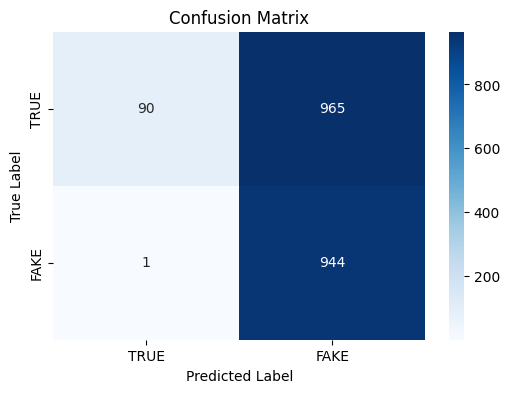

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['TRUE', 'FAKE'], yticklabels=['TRUE', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## **Result for un preprocessed text**

In [ ]:
max_length = 512
results2 = clf(sample_ds2['text'],truncation=True, max_length=max_length)
results2 # Resuluts for the non preprocessed data
#LABEL_0: Fake news
#LABEL_1: Real news

[{'label': 'LABEL_0', 'score': 0.9997510313987732},
 {'label': 'LABEL_0', 'score': 0.9996711015701294},
 {'label': 'LABEL_1', 'score': 0.999909520149231},
 {'label': 'LABEL_0', 'score': 0.9997453093528748},
 {'label': 'LABEL_0', 'score': 0.999729573726654},
 {'label': 'LABEL_0', 'score': 0.9997362494468689},
 {'label': 'LABEL_1', 'score': 0.9999120235443115},
 {'label': 'LABEL_1', 'score': 0.9999140501022339},
 {'label': 'LABEL_0', 'score': 0.9997562766075134},
 {'label': 'LABEL_0', 'score': 0.9987830519676208},
 {'label': 'LABEL_1', 'score': 0.9999135732650757},
 {'label': 'LABEL_1', 'score': 0.9999126195907593},
 {'label': 'LABEL_0', 'score': 0.9993274211883545},
 {'label': 'LABEL_1', 'score': 0.9999138116836548},
 {'label': 'LABEL_0', 'score': 0.9997455477714539},
 {'label': 'LABEL_1', 'score': 0.9999120235443115},
 {'label': 'LABEL_1', 'score': 0.9999127388000488},
 {'label': 'LABEL_1', 'score': 0.9999145269393921},
 {'label': 'LABEL_1', 'score': 0.999911904335022},
 {'label': 'LAB

In [ ]:
true_labels2 = ds2[0:2000]['label'] # Actual labels
# Convert the true labels to match the model's label format
true_labels_mapped2 = ['LABEL_1' if label == 1 else 'LABEL_0' for label in true_labels2]
# Predicted labels, ensure they are in the same format
predicted_labels2 = [result['label'] for result in results2]

# Create a DataFrame to compare true and predicted labels
comparison_df2 = pd.DataFrame({
    'True Label': true_labels_mapped2,
    'Predicted Label': predicted_labels2,
    'Confidence Score': [result['score'] for result in results2]
})
comparison_df2

,True Label,Predicted Label,Confidence Score
0,LABEL_0,LABEL_0,0.999751
1,LABEL_0,LABEL_0,0.999671
2,LABEL_1,LABEL_1,0.999910
3,LABEL_0,LABEL_0,0.999745
4,LABEL_0,LABEL_0,0.999730
...,...,...,...
1995,LABEL_0,LABEL_0,0.999561
1996,LABEL_0,LABEL_0,0.999566
1997,LABEL_1,LABEL_1,0.999913
1998,LABEL_1,LABEL_1,0.999912


In [ ]:

# Calculate accuracy
accuracy2 = accuracy_score(true_labels_mapped2, predicted_labels2)
f"Accuracy2: {accuracy2 * 100:.2f}%"

'Accuracy2: 97.85%'

In [ ]:
# Generate the confusion matrix
conf_matrix2 = confusion_matrix(true_labels_mapped2, predicted_labels2, labels=['LABEL_1', 'LABEL_0'])
conf_matrix2

array([[1012,   43],
       [   0,  945]])

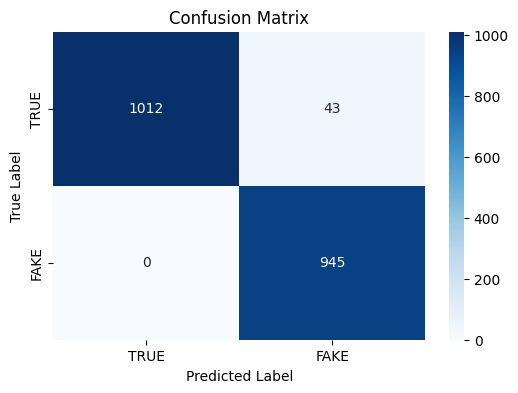

In [ ]:

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap="Blues", xticklabels=['TRUE', 'FAKE'], yticklabels=['TRUE', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Resuluts for title**

In [ ]:
max_length = 512
results_title = clf(sample_ds['title'],truncation=True, max_length=max_length)
results_title # Results based on the title and not text of the news
#LABEL_0: Fake news
#LABEL_1: Real news

[{'label': 'LABEL_0', 'score': 0.99849534034729},
 {'label': 'LABEL_0', 'score': 0.9988620281219482},
 {'label': 'LABEL_1', 'score': 0.9994438290596008},
 {'label': 'LABEL_0', 'score': 0.9990246295928955},
 {'label': 'LABEL_0', 'score': 0.9991376399993896},
 {'label': 'LABEL_0', 'score': 0.9944934844970703},
 {'label': 'LABEL_1', 'score': 0.9997709393501282},
 {'label': 'LABEL_1', 'score': 0.9228875041007996},
 {'label': 'LABEL_0', 'score': 0.9989140033721924},
 {'label': 'LABEL_0', 'score': 0.9980975985527039},
 {'label': 'LABEL_1', 'score': 0.9353111982345581},
 {'label': 'LABEL_1', 'score': 0.9998214840888977},
 {'label': 'LABEL_0', 'score': 0.9984709620475769},
 {'label': 'LABEL_1', 'score': 0.9997922778129578},
 {'label': 'LABEL_0', 'score': 0.9988586902618408},
 {'label': 'LABEL_1', 'score': 0.9995520710945129},
 {'label': 'LABEL_1', 'score': 0.9994462132453918},
 {'label': 'LABEL_1', 'score': 0.999244213104248},
 {'label': 'LABEL_1', 'score': 0.9998966455459595},
 {'label': 'LAB

In [ ]:
true_labels3 = ds[0:2000]['label'] # Actual labels
# Convert the true labels to match the model's label format
true_labels_mapped3 = ['LABEL_1' if label == 1 else 'LABEL_0' for label in true_labels3]
# Predicted labels, ensure they are in the same format
predicted_labels3 = [result['label'] for result in results_title]

# Create a DataFrame to compare true and predicted labels
comparison_df3 = pd.DataFrame({
    'True Label': true_labels_mapped2,
    'Predicted Label': predicted_labels2,
    'Confidence Score': [result['score'] for result in results_title]
})
comparison_df3

,True Label,Predicted Label,Confidence Score
0,LABEL_0,LABEL_0,0.998495
1,LABEL_0,LABEL_0,0.998862
2,LABEL_1,LABEL_1,0.999444
3,LABEL_0,LABEL_0,0.999025
4,LABEL_0,LABEL_0,0.999138
...,...,...,...
1995,LABEL_0,LABEL_0,0.996855
1996,LABEL_0,LABEL_0,0.903472
1997,LABEL_1,LABEL_1,0.995457
1998,LABEL_1,LABEL_1,0.999857


In [ ]:
# Calculate accuracy
accuracy3 = accuracy_score(true_labels_mapped3, predicted_labels3)
f"Accuracy3: {accuracy3 * 100:.2f}%"

'Accuracy3: 86.85%'

In [ ]:
# Generate the confusion matrix
conf_matrix3 = confusion_matrix(true_labels_mapped3, predicted_labels3, labels=['LABEL_1', 'LABEL_0'])
conf_matrix3

array([[808, 247],
       [ 16, 929]])

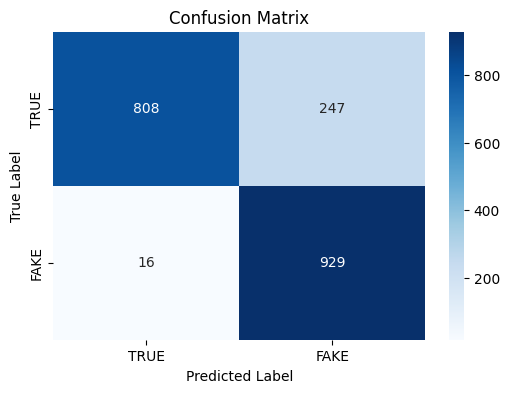

In [ ]:

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix3, annot=True, fmt="d", cmap="Blues", xticklabels=['TRUE', 'FAKE'], yticklabels=['TRUE', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()